# Anomaly detection on traceroute measurements
The goal for this Jupyter Notebook is to gain a better understanding off how the traceroute measurement data looks and in what way we can detect anomalies in the data.

The data selected is from an anchoring measurement towards an anchor located in San Fransisco, around the time of an internet outage from Fastly [1].
According to the article the outage should be around 11:00 UTC on june 8th. 

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import perf_counter
from measurement_import import TracerouteImport
from sklearn.ensemble import IsolationForest
from luminol.anomaly_detector import AnomalyDetector
from adtk.detector import InterQuartileRangeAD, PersistAD, LevelShiftAD

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data

Using a special helper function that gets the round trip time (RTT) of the last hop before entering the network of the personal AS. 

In [55]:
traceroute_import = TracerouteImport()
df = traceroute_import.read_dataset('measurement_data/traceroute-34761880.json')
df

,probe_id,created,total_hops,pre_entry_hop_min_rtt,pre_entry_hop_ip,pre_entry_as
0,1000067,2022-01-10 00:07:08+00:00,14,184.710,103.87.184.123,136106
1,10003,2022-01-10 00:07:02+00:00,12,185.559,114.5.178.138,4761
2,1000440,2022-01-10 00:07:05+00:00,13,195.732,103.87.184.123,136106
3,1000647,2022-01-10 00:07:12+00:00,13,201.101,114.5.178.138,4761
4,1000779,2022-01-10 00:07:10+00:00,13,209.106,114.5.178.138,4761
...,...,...,...,...,...,...
55613,55683,2022-01-11 11:37:06+00:00,11,195.339,114.5.178.138,4761
55614,55775,2022-01-11 11:37:08+00:00,10,197.098,103.87.184.123,136106
55615,599,2022-01-11 11:37:01+00:00,12,177.265,103.87.184.123,136106
55616,684,2022-01-11 11:37:15+00:00,15,306.375,114.5.178.138,4761


## Reformat Data

The following helper functions combined with running those on the dataset allow to make multivariate visualisations from the measurement data.

In [56]:
def calc_score(median, hops):
    if hops is None:
        return 0
    return abs(float(hops) - median)

def normalize(min_score, max_score, score):
    if max_score-min_score == 0:
        return 0
    return (score-min_score) / (max_score-min_score)

# def get_country_code(probe_id):
#     response = requests.get(f"https://atlas.ripe.net/api/v2/probes/{probe_id}").json()
#     return response['country_code']

In [57]:
unique_probes = df['probe_id'].unique()

for probe_id in unique_probes:
    hops_series_probe = df[df['probe_id'] == probe_id]['pre_entry_hop_min_rtt']
    median = hops_series_probe.median()
    scores = hops_series_probe.apply(lambda min_rtt: calc_score(median, min_rtt))
    score_max = scores.max()
    score_min = scores.min()
    normalized_scores = scores.apply(lambda score: normalize(score_min, score_max, score))
    df.loc[df['probe_id'] == probe_id, 'median_probe_hops'] = median
    df.loc[df['probe_id'] == probe_id, 'not_normalized_score'] = scores
    df.loc[df['probe_id'] == probe_id, 'normalized_score'] = normalized_scores
df

,probe_id,created,total_hops,pre_entry_hop_min_rtt,pre_entry_hop_ip,pre_entry_as,median_probe_hops,not_normalized_score,normalized_score
0,1000067,2022-01-10 00:07:08+00:00,14,184.710,103.87.184.123,136106,184.647,0.063,0.042254
1,10003,2022-01-10 00:07:02+00:00,12,185.559,114.5.178.138,4761,185.448,0.111,0.007239
2,1000440,2022-01-10 00:07:05+00:00,13,195.732,103.87.184.123,136106,195.689,0.043,0.065053
3,1000647,2022-01-10 00:07:12+00:00,13,201.101,114.5.178.138,4761,200.201,0.900,0.239044
4,1000779,2022-01-10 00:07:10+00:00,13,209.106,114.5.178.138,4761,210.113,1.007,0.374628
...,...,...,...,...,...,...,...,...,...
55613,55683,2022-01-11 11:37:06+00:00,11,195.339,114.5.178.138,4761,176.278,19.061,0.999738
55614,55775,2022-01-11 11:37:08+00:00,10,197.098,103.87.184.123,136106,197.107,0.009,0.000672
55615,599,2022-01-11 11:37:01+00:00,12,177.265,103.87.184.123,136106,177.193,0.072,0.000000
55616,684,2022-01-11 11:37:15+00:00,15,306.375,114.5.178.138,4761,303.324,3.051,0.398719


## Amount of probes per neighbor AS

The amount of probes that reach the target through different AS numbers, to see how important a neigboring AS is to the target and to see if there are enough different measurements. 

In [49]:
df['pre_entry_as'].value_counts()

4761      25954
136106    19760
17922      1422
6453        383
5384        286
1299        286
10217       280
4651        143
9002          1
31214         1
327687        1
812           1
36944         1
8228          1
Name: pre_entry_as, dtype: int64

<AxesSubplot:>

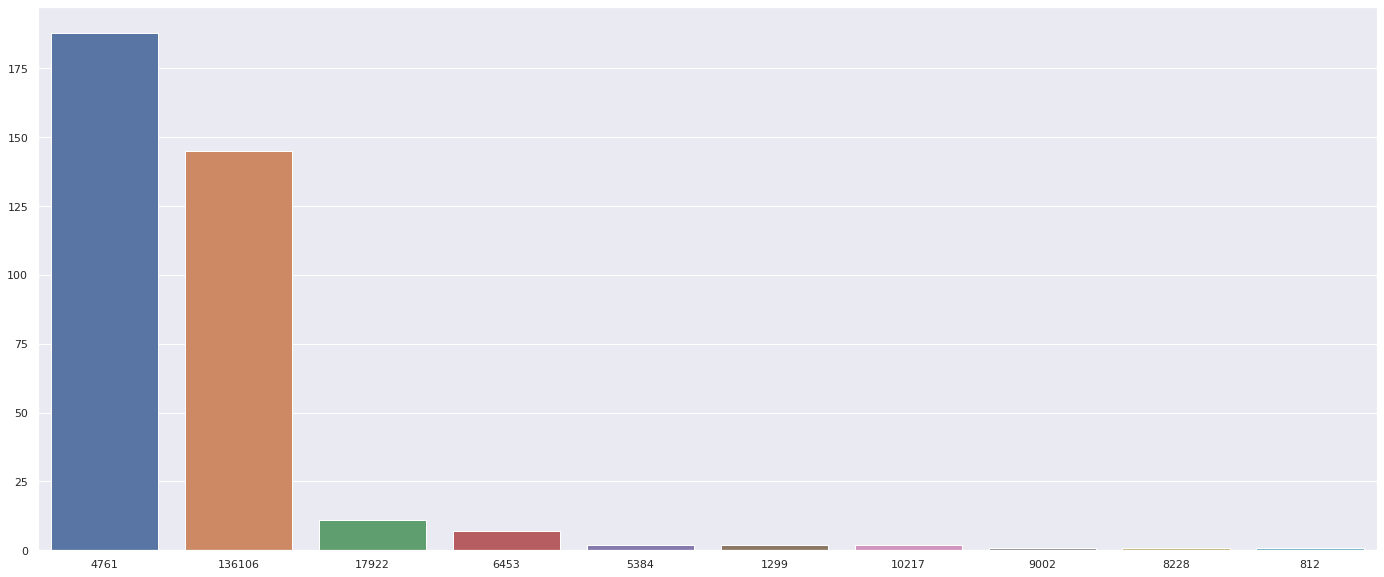

In [58]:
probes_in_as = []
unique_as_num = df['pre_entry_as'].unique()
for as_num in unique_as_num:
    single_as_df = df[df['pre_entry_as'] == as_num]
    probes_in_as.append(len(single_as_df['probe_id'].unique()))

unique_as_num = [x for y, x in sorted(zip(probes_in_as, unique_as_num), reverse=True)]
probes_in_as.sort(reverse=True)
sns.set(rc={"figure.figsize":(24, 10)})
sns.barplot(x=unique_as_num[:10], y=probes_in_as[:10])

##  RTT Multivariate Plot per probe

A plot where a higher round trip time results in a darker dot for a certain moment, the x-axis shows the time, the y-axis shows unique probes that the data is collected from. If there is a similar pattern (dots getting darker) over different probes, this means that the anomaly can be detected from different sensors and therefore is more likely to be an actual problem instead of just noise in the signal.

<AxesSubplot:xlabel='created', ylabel='probe_id'>

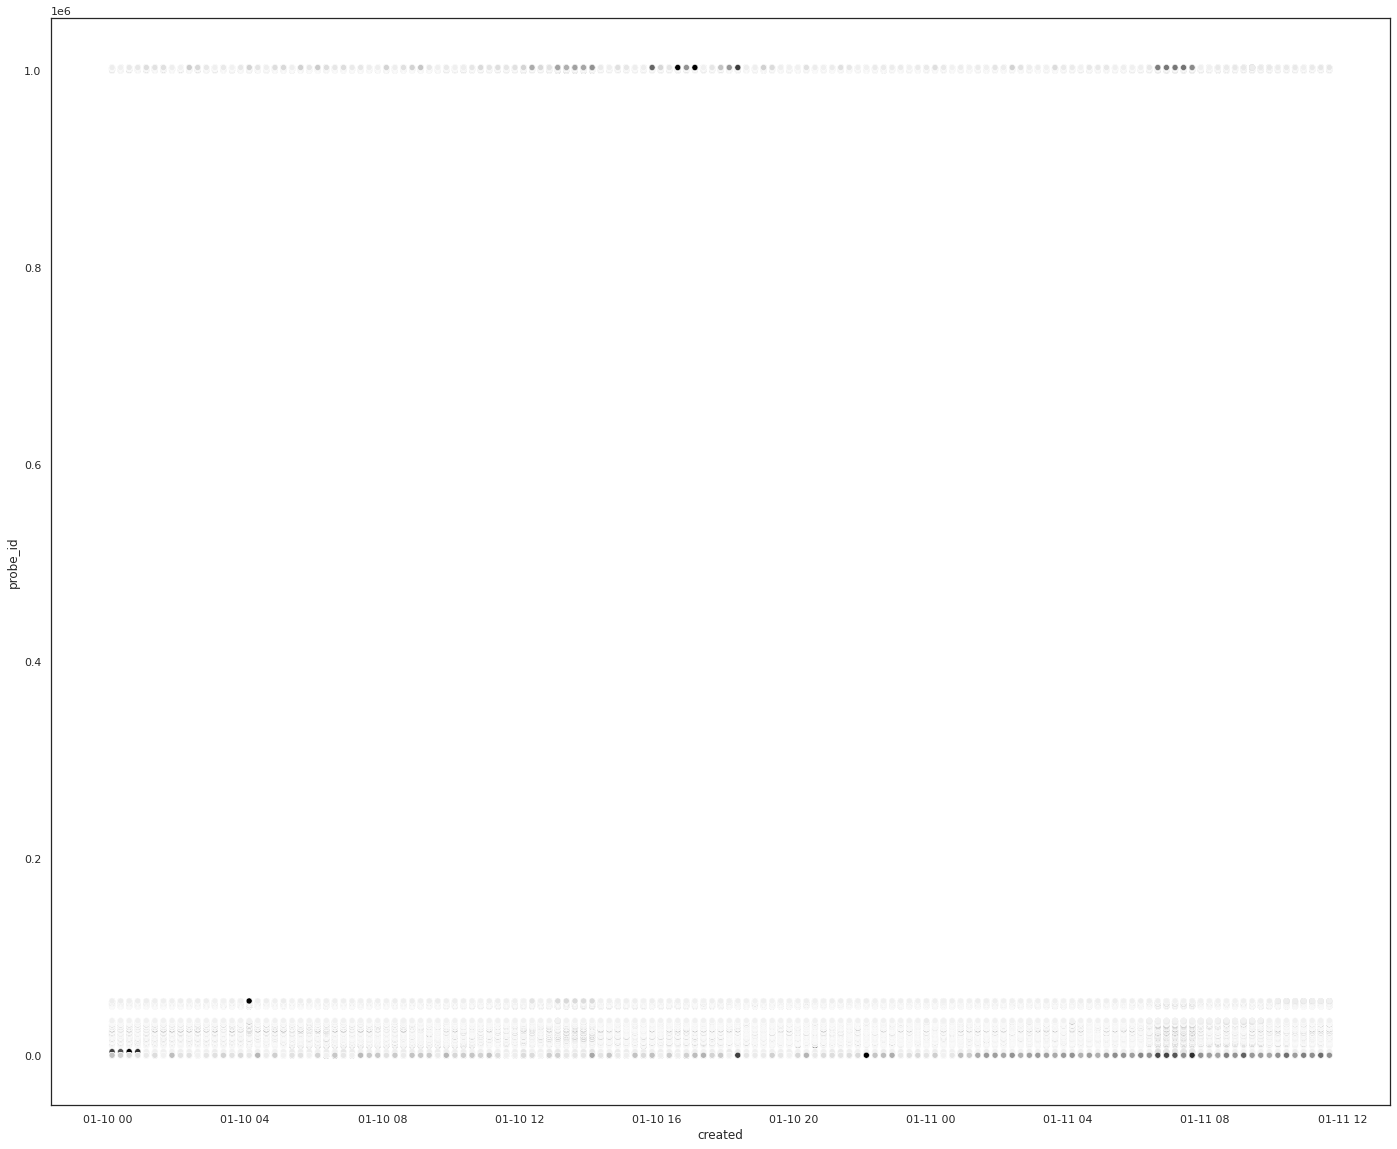

In [59]:
sns.set(rc={"figure.figsize":(24, 20)})
sns.set_style("white")
sns.scatterplot(data=df, x="created", y="probe_id", hue="normalized_score",legend=False, palette="light:black")

##  RTT Multivariate Plot per AS number

A plot where a higher round trip time results in a darker dot for a certain moment, the x-axis shows the time, the y-axis shows probe-id's within a AS of neighboring connections.

<AxesSubplot:xlabel='created', ylabel='probe_id'>

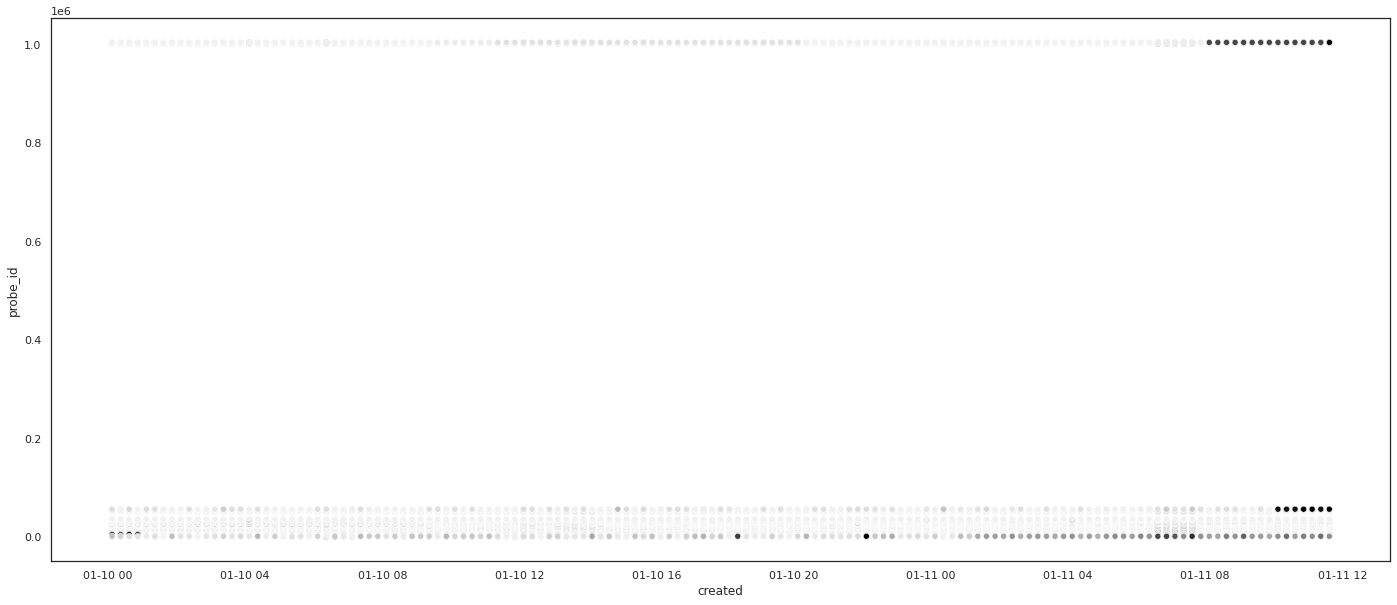

In [60]:
as_num = '4761'
single_as_df = df[df['pre_entry_as'] == as_num]

sns.set(rc={"figure.figsize":(24, 10)})
sns.set_style("white")
sns.scatterplot(data=single_as_df, x="created", y="probe_id", hue="normalized_score",legend=False, palette="light:black")

## anomaly detection on single probe

The following section compares different anomaly detection algorithms. Since there is no ground truth data this has to happen visually by judging if the anomaly points line up with expectiations. An anomaly is either shown as a red dot or a red line.

The first code block allows the selection of a probe (either random, or select by choosing a probe id). After that there are graphs of different anomaly detection algorithms.

In [61]:
#interesting_random_state = {9, 13}
random_probe = df["probe_id"].sample(n=1, random_state=1).unique()[0]
# random_probe = 6436
print(f"Probe ID: {random_probe}")
single_probe = df[df["probe_id"] == random_probe]

baseline = single_probe[single_probe['created'] < '2021-06-08']
check_range = single_probe[(single_probe['created'] < '2021-06-09') & (single_probe['created'] > '2021-06-08')]
single_probe

Probe ID: 1002950


,probe_id,created,total_hops,pre_entry_hop_min_rtt,pre_entry_hop_ip,pre_entry_as,median_probe_hops,not_normalized_score,normalized_score
79,1002950,2022-01-10 00:07:13+00:00,14,183.519,103.87.184.123,136106,193.102,9.583,0.215999
471,1002950,2022-01-10 00:22:02+00:00,14,183.644,103.87.184.123,136106,193.102,9.458,0.213181
858,1002950,2022-01-10 00:37:15+00:00,14,183.181,103.87.184.123,136106,193.102,9.921,0.223617
1248,1002950,2022-01-10 00:52:08+00:00,14,183.685,103.87.184.123,136106,193.102,9.417,0.212257
1636,1002950,2022-01-10 01:07:16+00:00,14,185.427,103.87.184.123,136106,193.102,7.675,0.172993
...,...,...,...,...,...,...,...,...,...
53763,1002950,2022-01-11 10:37:03+00:00,14,193.680,103.87.184.123,136106,193.102,0.578,0.013028
54149,1002950,2022-01-11 10:52:09+00:00,14,193.027,103.87.184.123,136106,193.102,0.075,0.001690
54536,1002950,2022-01-11 11:07:02+00:00,14,193.086,103.87.184.123,136106,193.102,0.016,0.000361
54923,1002950,2022-01-11 11:22:03+00:00,14,193.050,103.87.184.123,136106,193.102,0.052,0.001172


### Isolation Forest

Algorithm based on decison tree's from Scikit learn

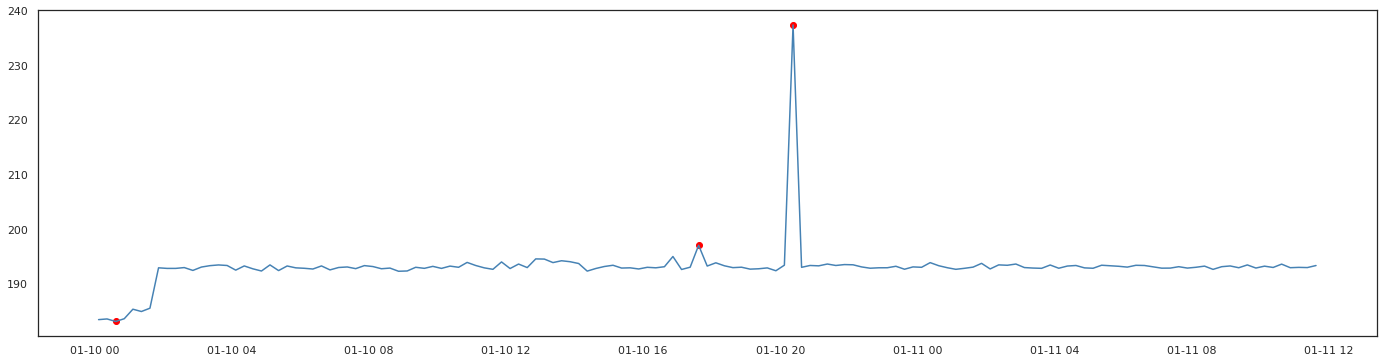

Run Time: 0.2238644099998055


In [65]:
start_if = perf_counter()
if_clf = IsolationForest(contamination=0.02)
single_probe["isolation_forest"] = if_clf.fit_predict(single_probe[["pre_entry_hop_min_rtt"]])
lenght_if = perf_counter() - start_if

fig, ax = plt.subplots(figsize=(24,6))

isolation_f = single_probe.loc[single_probe['isolation_forest'] == -1, ['created', 'pre_entry_hop_min_rtt']]
ax.scatter(isolation_f["created"], isolation_f["pre_entry_hop_min_rtt"], color="red")

# ax.plot(check_range['created'], check_range['pre_entry_hop_mean_rtt'], color='lightgrey')
ax.plot(single_probe['created'], single_probe['pre_entry_hop_min_rtt'], color='steelblue')

plt.show()
print(f'Run Time: {lenght_if}')

### Luminol

Algorithm developed by Linkedin

11.41860130007691
Run Time: 0.0010897719985223375


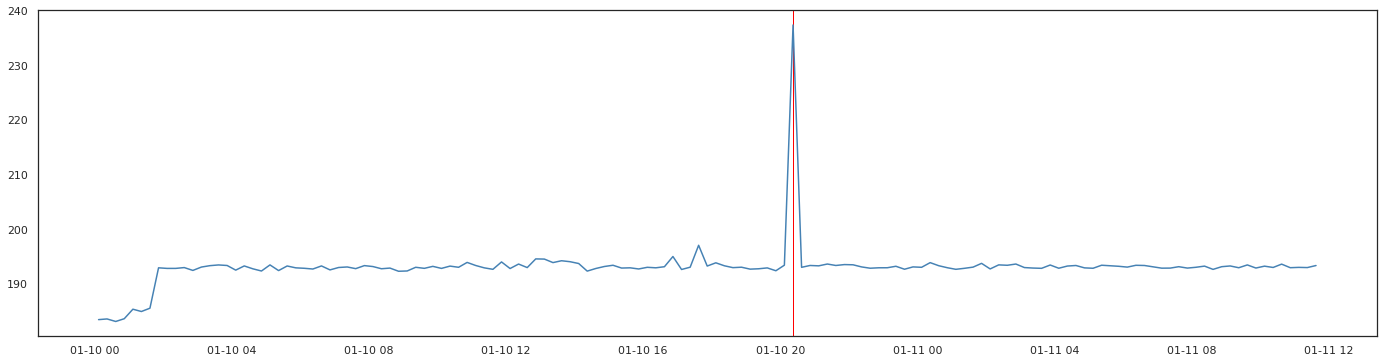

In [66]:
# Anomaly detection settings
algo_settings = {
        'smoothing_factor': 0.01,
    }

start_luminol = perf_counter()
# ts_baseline = baseline["pre_entry_hop_min_rtt"].to_dict()
ts_check = single_probe["pre_entry_hop_min_rtt"].to_dict()
detector = AnomalyDetector(ts_check, algorithm_name="exp_avg_detector", algorithm_params=algo_settings)
anomalies = detector.get_anomalies()
lenght_luminol = perf_counter() - start_luminol

for anomaly in anomalies:
    print(anomaly.anomaly_score)
fig, ax = plt.subplots(figsize=(24,6))

for anomaly in anomalies:
    start = single_probe.at[anomaly.start_timestamp, "created"]
    end = single_probe.at[anomaly.end_timestamp, "created"]
    score = anomaly.anomaly_score
    ax.axvspan(xmin=start, xmax=end, color="red")

# ax.plot(check_range['created'], check_range['pre_entry_hop_mean_rtt'], color='lightgrey')
ax.plot(single_probe['created'], single_probe['pre_entry_hop_min_rtt'], color='steelblue')

print(f'Run Time: {lenght_luminol}')

In [67]:
from adtk.data import validate_series
from adtk.visualization import plot

# Convert for the anomaly detection toolkit
single_probe.set_index('created', inplace=True)
ts = single_probe['pre_entry_hop_min_rtt']
ts = validate_series(ts)

### Inter Quartile Range

From the anomaly detection toolkit.

Run Time: 0.009166412004560698


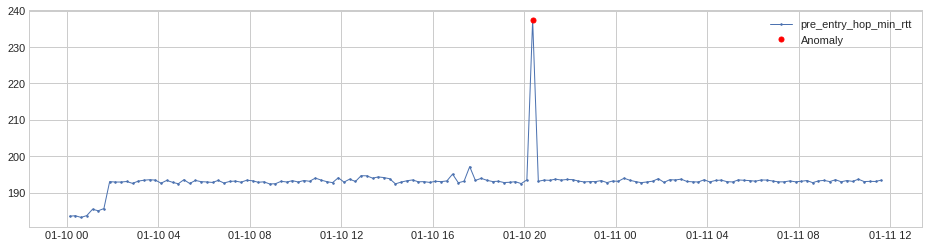

In [68]:
start = perf_counter()
iqr_ad = InterQuartileRangeAD(c=50)
iqr_anomalies = iqr_ad.fit_detect(ts)
lenght = perf_counter() - start

plot(ts, anomaly=iqr_anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")
print(f'Run Time: {lenght}')

### Persist AD

Anomaly detection toolkit

Run Time: 0.022913585999049246


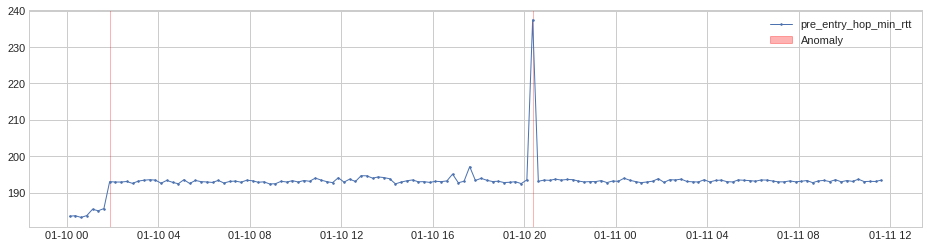

In [69]:
start = perf_counter()
persist_ad = PersistAD(c=20.0, side='positive', window=3)
persist_anomalies = persist_ad.fit_detect(ts)
lenght = perf_counter() - start

plot(ts, anomaly=persist_anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red')
print(f'Run Time: {lenght}')

### Level Shift

Anomaly Detection Toolkit

nan
nan
nan
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
nan
nan
Run Time: 0.018081511996570043


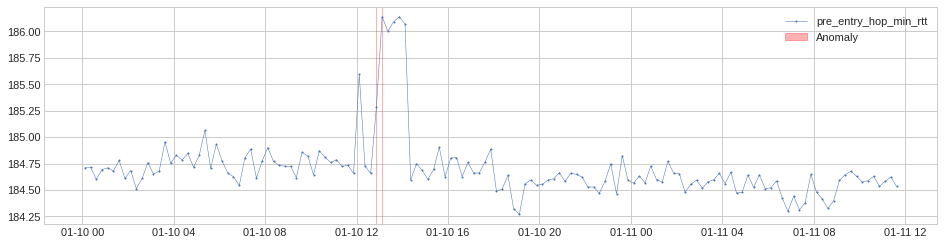

In [79]:
start = perf_counter()
level_shift_ad = LevelShiftAD(c=10.0, side='positive', window=3)
level_anomalies = level_shift_ad.fit_detect(ts)
lenght = perf_counter() - start

for i in level_anomalies:
    print(i)

plot(ts, anomaly=level_anomalies, anomaly_color='red')
print(f'Run Time: {lenght}')

In [ ]:
)
lenght = perf_counter() - start

print(level_anomalies)

plot(ts, anomaly=level_anomalies, anomaly_color='red')
print(f'Run Time: {lenght}')

## Visualize RTT for one AS
The next graph shows the minimum round trip time of the last hop before the own AS.

AS Number: 4761, probes in AS: 188


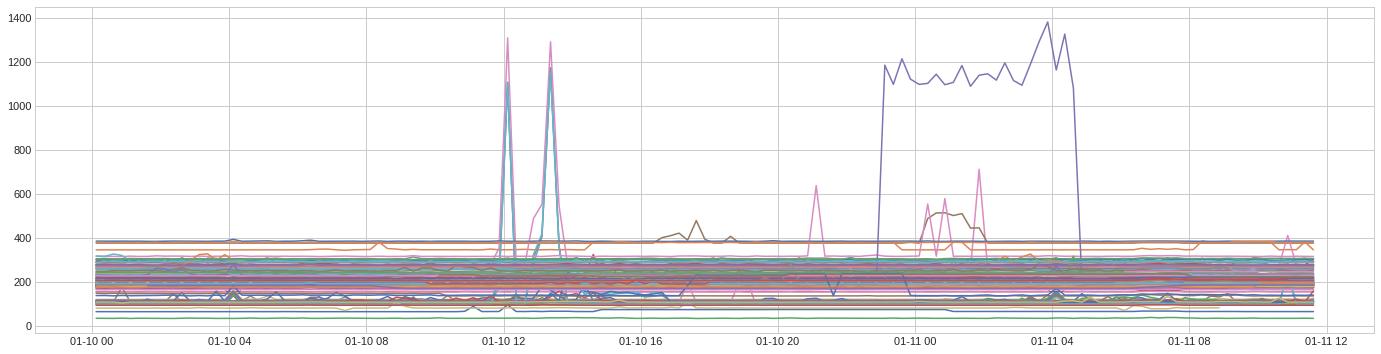

In [71]:
# random_as = df["pre_entry_as"].dropna().sample(n=1, random_state=1).unique()[0]
random_as = '4761'
single_as = df[df["pre_entry_as"] == random_as]
probes_in_as = len(pd.unique(single_as['probe_id']))
print(f'AS Number: {random_as}, probes in AS: {probes_in_as}')
fig, ax = plt.subplots(figsize=(24,6))

for probe in single_as['probe_id'].unique():
    single_probe = single_as[single_as["probe_id"] == probe]
    ax.plot(single_probe['created'], single_probe['pre_entry_hop_min_rtt'])

# single_probe.set_index('created', inplace=True)
# ts = single_probe['pre_entry_hop_min_rtt']
# ts = validate_series(ts)

In [83]:
# Find outliers in total dataset
iqr_ad = InterQuartileRangeAD(c=50)
level_shift = LevelShiftAD(c=10.0, side='positive', window=3)
persist_ad = PersistAD(c=20.0, side='positive', window=3)

df_outlier = pd.DataFrame()
for probe_id in df["probe_id"].unique():
    # print(probe_id)
    single_probe = df[df["probe_id"] == probe_id]

    single_probe.set_index('created', inplace=True)
    ts = single_probe['pre_entry_hop_min_rtt']
    ts = validate_series(ts)

    try:
        single_probe["inter_quartile"] = iqr_ad.fit_detect(ts)
        single_probe["persist"] = persist_ad.fit_detect(ts)
        single_probe["level_shift"] = level_shift.fit_detect(ts)
        df_outlier = df_outlier.append(single_probe)
    except RuntimeError:
        pass

df_outlier

,probe_id,total_hops,pre_entry_hop_min_rtt,pre_entry_hop_ip,pre_entry_as,median_probe_hops,not_normalized_score,normalized_score,inter_quartile,persist,level_shift
created,,,,,,,,,,,
2022-01-10 00:07:08+00:00,1000067,14,184.710,103.87.184.123,136106,184.6470,0.0630,0.042254,False,NaN,NaN
2022-01-10 00:22:13+00:00,1000067,14,184.713,103.87.184.123,136106,184.6470,0.0660,0.044266,False,NaN,NaN
2022-01-10 00:37:08+00:00,1000067,14,184.601,103.87.184.123,136106,184.6470,0.0460,0.030852,False,NaN,NaN
2022-01-10 00:52:09+00:00,1000067,14,184.693,103.87.184.123,136106,184.6470,0.0460,0.030852,False,False,False
2022-01-10 01:07:13+00:00,1000067,14,184.709,103.87.184.123,136106,184.6470,0.0620,0.041583,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-10 21:37:04+00:00,14277,14,257.608,116.0.74.7,6453,259.6715,2.0635,0.027393,False,False,False
2022-01-10 21:52:09+00:00,14277,15,257.492,180.87.67.32,6453,259.6715,2.1795,0.029110,False,False,False
2022-01-10 22:07:10+00:00,14277,14,257.109,116.0.74.9,6453,259.6715,2.5625,0.034781,False,False,False


<AxesSubplot:xlabel='created'>

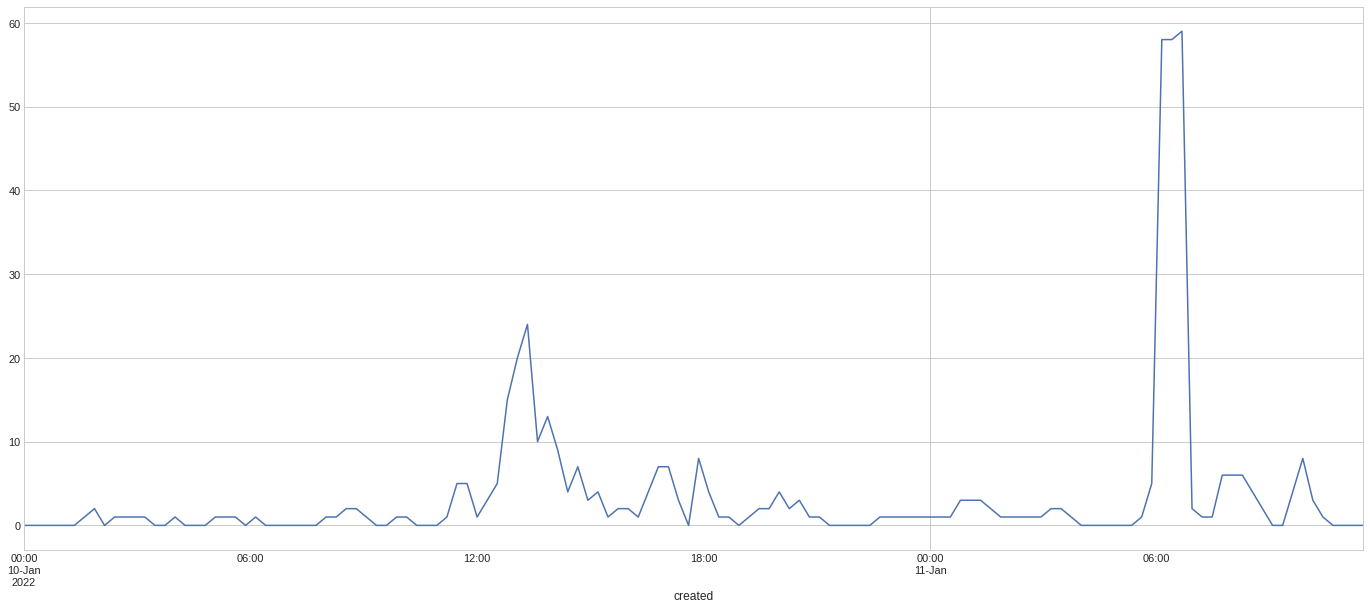

In [87]:
# Create anomaly score frame
# unique_as_num = df['pre_entry_as'].unique()
# for as_num in unique_as_num:
#     single_as_df = df[df['pre_entry_as'] == as_num]
#     probes_in_as.append(len(single_as_df['probe_id'].unique()))
as_num = '4761'
single_as_df = df_outlier[df_outlier['pre_entry_as'] == as_num]
single_as_df
single_as_df.groupby(pd.Grouper(freq="16T"))["level_shift"].agg("sum").plot()

<AxesSubplot:xlabel='created'>

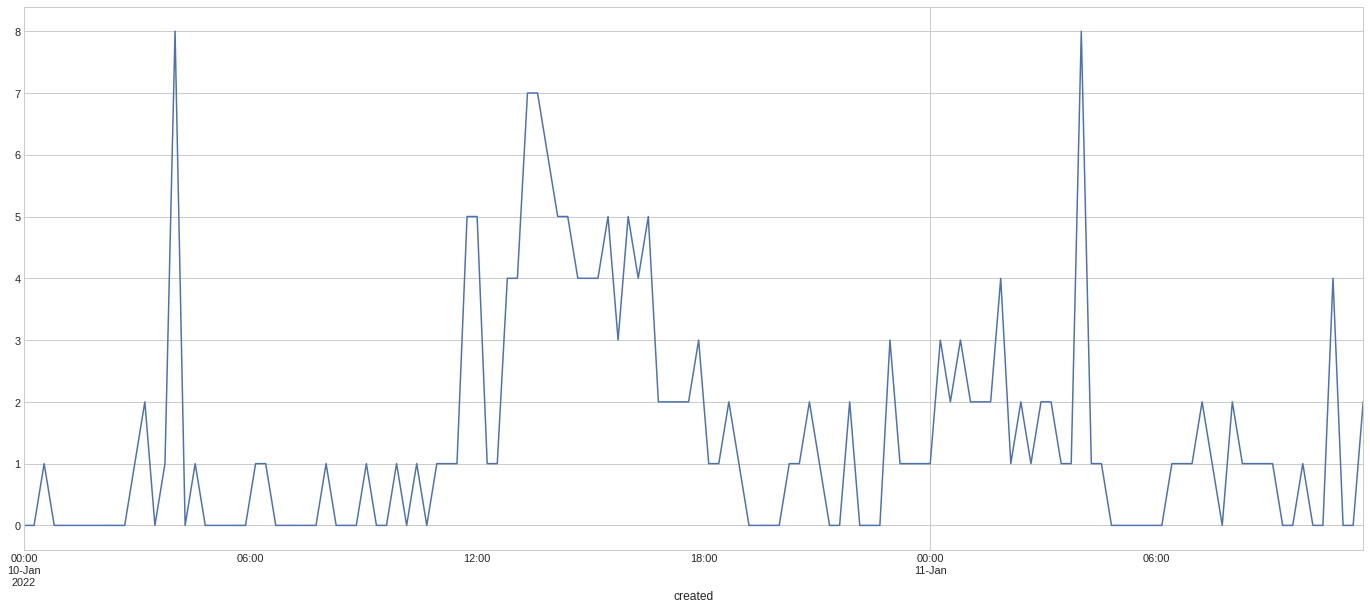

In [84]:
as_num = '4761'
single_as_df = df_outlier[df_outlier['pre_entry_as'] == as_num]
single_as_df
single_as_df.groupby(pd.Grouper(freq="16T"))["inter_quartile"].agg("sum").plot()

<AxesSubplot:xlabel='created'>

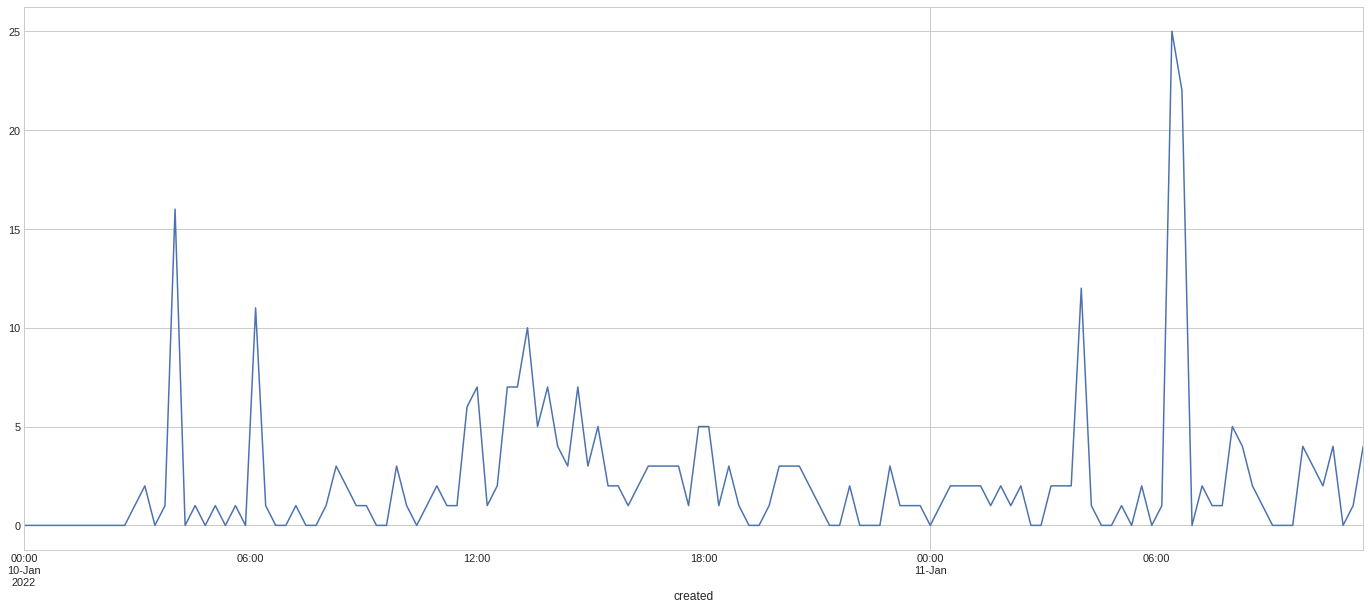

In [85]:
as_num = '4761'
single_as_df = df_outlier[df_outlier['pre_entry_as'] == as_num]
single_as_df
single_as_df.groupby(pd.Grouper(freq="16T"))["persist"].agg("sum").plot()